# Takes a lot of time

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM
from bresenham import bresenham
from scipy.interpolate import interp1d
import pytesseract
import Levenshtein as lev

merged_points = []

n1_splines = 6
n2_splines = 12

def divide_arc_length(X, Y, n):


    dx = np.diff(X)
    dy = np.diff(Y)

    # Calculate the arc length increments
    ds = np.sqrt(dx**2 + dy**2)

    s = np.concatenate(([0], np.cumsum(ds)))

    # Total arc length
    L = s[-1]
    Delta_L = L / n

    # Find the points x_i
    x_points = [X[0]]  # Start with the initial point

    for i in range(1, n):
        target_length = i * Delta_L

        # Interpolating the x value at the target arc length
        idx = np.searchsorted(s, target_length)
        x0, x1 = X[idx-1], X[idx]
        s0, s1 = s[idx-1], s[idx]

        # Linear interpolation for the x value at the target arc length
        x_interp = x0 + (target_length - s0) * (x1 - x0) / (s1 - s0)
        x_points.append(x_interp)

    x_points.append(X[-1])  # Include the endpoint

    return x_points

def reshape_array_with_interpolation(original_array, new_size, kind='linear'):

    # Original indices based on the original array size
    original_indices = np.linspace(0, len(original_array) - 1, len(original_array))

    # New indices for the desired output shape
    new_indices = np.linspace(0, len(original_array) - 1, new_size)

    # Use interpolation
    interpolation_function = interp1d(original_indices, original_array, kind=kind)

    # Interpolate to find new values
    new_array = interpolation_function(new_indices)

    return np.round(new_array)

def pad_binary_image_with_ones(image):
    # Get the original image dimensions
    original_height, original_width = image.shape

    # Create a new array of ones with double the dimensions of the original image
    new_height = 2 * original_height
    new_width = 2 * original_width
    padded_image = np.ones((new_height, new_width), dtype=image.dtype) + 254

    # Copy the original image into the center of the new array
    start_row = original_height // 2
    start_col = original_width // 2
    padded_image[start_row:start_row + original_height, start_col:start_col + original_width] = image

    return padded_image

def find_distance_d(X, y, X_new, y_hat, step):
    # Starting point for the distance d
    d = 0
    max_iterations = 1000  # Prevent infinite loops
    iteration = 0
    found = False

    # Increment d until all points are covered or max_iterations is reached
    while iteration < max_iterations and not found:
        # Create two functions shifted by d
        upper_function = y_hat + d
        lower_function = y_hat - d

        # Check if all y points are within the bounds
        all_points_covered = np.all([(y[i] <= upper_function[np.argmin(np.abs(X_new - X[i]))]) and
                                    (y[i] >= lower_function[np.argmin(np.abs(X_new - X[i]))]) for i in range(len(X_new))])

        if all_points_covered:
            found = True
        else:
            d += step  # Increment d
            iteration += 1

    return int(np.ceil(2*d))

def calculate_derivative(y_values):
    dy = np.zeros(y_values.shape)
    dy[0] = y_values[1] - y_values[0]  # Forward difference
    dy[-1] = y_values[-1] - y_values[-2]  # Backward difference
    dy[1:-1] = (y_values[2:] - y_values[:-2]) / 2  # Central difference
    return dy

def find_perpendicular_points(y_values, x_values, d):
    dy = calculate_derivative(y_values)
    perpendicular_points = []

    for i, (x, y) in enumerate(zip(x_values, y_values)):
        slope = dy[i]
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = np.inf

        if np.isinf(perp_slope):  # Vertical line
            points = [(round(x), round(y - d)), (round(x), round(y + d))]
        else:
            # y = mx + c form for perpendicular line
            c = y - perp_slope * x
            # Solve for points that are distance d away from (x, y)
            delta = d / np.sqrt(1 + perp_slope**2)
            x1, x2 = x + delta, x - delta
            y1, y2 = perp_slope * x1 + c, perp_slope * x2 + c
            points = [(round(x1), round(y1)), (round(x2), round(y2))]

        perpendicular_points.append(points)

    return perpendicular_points

def uncurve_text_tight(input_path, output_path, n_splines,show_plot,arc_equal=False):
    # Load image, grayscale it, Otsu's threshold
    image = input_path
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    global merged_points
    # Dilation & Erosion to fill holes inside the letters
    kernel = np.ones((3, 3), np.uint8)
    # thresh = cv2.erode(thresh, kernel, iterations=1)
    # thresh = cv2.dilate(thresh, kernel, iterations=1)

    threshold_value = 30  # Adjust as needed

    black_pixels = np.column_stack(np.where(thresh <= threshold_value))
    leftmost_x = np.min(black_pixels[:, 1]) - int(0.05*(np.max(black_pixels[:, 1]) - np.min(black_pixels[:, 1])))
    rightmost_x = np.max(black_pixels[:, 1]) + int(0.05*(np.max(black_pixels[:, 1]) - np.min(black_pixels[:, 1])))
    X = black_pixels[:, 1].reshape(-1, 1)
    y = black_pixels[:, 0]

    merged_points = list(zip(black_pixels[:, 1], black_pixels[:, 0]))
    #print(merged_points)


    gam = LinearGAM(n_splines = n_splines)
    gam.fit(X, y)

    if arc_equal!=True:
        X_new = np.linspace(leftmost_x, rightmost_x, num = rightmost_x - leftmost_x)
    else:
        # Generate a dense set of points for accurate arc length calculation
        X_dense = np.linspace(leftmost_x, rightmost_x, num = rightmost_x - leftmost_x)

        Y_dense = gam.predict(X_dense)

        #print(f'X_dense : {X_dense}')
        #print(f'Y_dense : {Y_dense}')

        # Interval and number of segments
        n = rightmost_x - leftmost_x  # Number of equal segments

        # Get the points dividing the arc length into equal segments
        X_new = divide_arc_length(X_dense, Y_dense, n)
        #print(f'X_new : {X_new}')

    # Create the offset necessary to un-curve the text
    y_hat = gam.predict(X_new)

    #print(f'Y_dense : {y_hat}')

    if(show_plot):
      # Plot the image with text curve overlay
      plt.imshow(thresh, cmap='gray')
      plt.plot(X_new, y_hat, color='red')
      plt.axis('off')
      plt.subplots_adjust(bottom = 0, left = 0, right = 1, top = 1)
      plt.show()



    # Calculate height of text
    d = find_distance_d(X, y, X_new, y_hat, step = 0.5)

    dewarp_image = np.zeros(((2*d+1), len(X_new)), dtype=np.uint8) + 255

    # Calculate perpendicular points
    perpendicular_points = find_perpendicular_points(y_hat, X_new, d)
    my_iter = 0

    for points in perpendicular_points:
        x1, y1, x2, y2 = [element for tup in points for element in tup]
        if y1 > y2:  # If y1 is below y2, swap them to ensure top-to-bottom interpolation
            y1, y2 = y2, y1
            x1, x2 = x2, x1
        # Extract pixel values
        bresenham_list = list(bresenham(x1, y1, x2, y2))
        # Extract pixel values, ensuring they are within the bounds of the image
        pixel_values = []
        for x, y in bresenham_list:
            # Clip x and y to image bounds
            x = np.clip(x, 0, thresh.shape[1] - 1)
            y = np.clip(y, 0, thresh.shape[0] - 1)
            pixel_values.append(thresh[y, x])

        dewarp_image[:, my_iter] = reshape_array_with_interpolation(np.array(pixel_values), (2*d+1), kind='linear')
        my_iter += 1

    if(show_plot):
      # Plot the original image
      plt.imshow(thresh, cmap='gray', extent=[0, thresh.shape[1], thresh.shape[0], 0])

      # Plot the y_hat line
      plt.plot(X_new, y_hat, color='red')

      # Plot perpendicular points
      for points in perpendicular_points:
        plt.plot([x[0] for x in points], [x[1] for x in points], color='blue', alpha=0.5)

      plt.axis('off')
      plt.subplots_adjust(bottom = 0, left = 0, right = 1, top = 1)
      plt.show()

      # Plot the final image
      plt.imshow(dewarp_image, cmap=plt.cm.gray)
      plt.axis('off')
      plt.subplots_adjust(bottom = 0, left = 0, right = 1, top = 1)
      plt.show()

    cv2.imwrite(output_path, dewarp_image)

# Takes less time

In [6]:
import cv2
import numpy as np
from pygam import LinearGAM
from bresenham import bresenham
from scipy.interpolate import interp1d
from numba import njit
import matplotlib.pyplot as plt

# === Configurable Parameters ===
n_splines = 6  # Fewer splines = faster fitting
threshold_value = 30  # For black pixel detection

# === Utility Functions ===

def divide_arc_length(X, Y, n):
    dx = np.diff(X)
    dy = np.diff(Y)
    ds = np.sqrt(dx**2 + dy**2)
    s = np.concatenate(([0], np.cumsum(ds)))
    L = s[-1]
    Delta_L = L / n
    x_points = [X[0]]
    for i in range(1, n):
        target_length = i * Delta_L
        idx = np.searchsorted(s, target_length)
        x0, x1 = X[idx - 1], X[idx]
        s0, s1 = s[idx - 1], s[idx]
        x_interp = x0 + (target_length - s0) * (x1 - x0) / (s1 - s0)
        x_points.append(x_interp)
    x_points.append(X[-1])
    return x_points

@njit
def calculate_derivative(y_values):
    dy = np.zeros_like(y_values)
    dy[0] = y_values[1] - y_values[0]
    dy[-1] = y_values[-1] - y_values[-2]
    for i in range(1, len(y_values) - 1):
        dy[i] = (y_values[i + 1] - y_values[i - 1]) / 2
    return dy

def find_perpendicular_points(y_values, x_values, d):
    dy = calculate_derivative(np.array(y_values))
    perp_points = []
    for i, (x, y) in enumerate(zip(x_values, y_values)):
        slope = dy[i]
        perp_slope = -1 / slope if slope != 0 else np.inf
        if np.isinf(perp_slope):
            pts = [(round(x), round(y - d)), (round(x), round(y + d))]
        else:
            c = y - perp_slope * x
            delta = d / np.sqrt(1 + perp_slope ** 2)
            x1, x2 = x + delta, x - delta
            y1, y2 = perp_slope * x1 + c, perp_slope * x2 + c
            pts = [(round(x1), round(y1)), (round(x2), round(y2))]
        perp_points.append(pts)
    return perp_points

def find_distance_d(X, y, X_new, y_hat, step):
    d, iteration, max_iter = 0, 0, 1000
    while iteration < max_iter:
        upper = y_hat + d
        lower = y_hat - d
        all_covered = all((y[i] >= lower[np.argmin(np.abs(X_new - X[i]))]) and 
                          (y[i] <= upper[np.argmin(np.abs(X_new - X[i]))])
                          for i in range(len(X_new)))
        if all_covered:
            break
        d += step
        iteration += 1
    return int(np.ceil(2 * d))

def uncurve_text_tight(image, output_path, n_splines=6, show_plot=False, arc_equal=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    black_pixels = np.column_stack(np.where(thresh <= threshold_value))
    X = black_pixels[:, 1].reshape(-1, 1)
    y = black_pixels[:, 0]
    left_x = np.min(black_pixels[:, 1])
    right_x = np.max(black_pixels[:, 1])

    gam = LinearGAM(n_splines=n_splines)
    gam.fit(X, y)

    if not arc_equal:
        X_new = np.linspace(left_x, right_x, num=right_x - left_x)
    else:
        X_dense = np.linspace(left_x, right_x, num=right_x - left_x)
        Y_dense = gam.predict(X_dense)
        X_new = divide_arc_length(X_dense, Y_dense, right_x - left_x)

    y_hat = gam.predict(X_new)

    if show_plot:
        plt.imshow(thresh, cmap='gray')
        plt.plot(X_new, y_hat, color='red')
        plt.axis('off')
        plt.show()

    d = find_distance_d(X.flatten(), y, X_new, y_hat, step=0.5)
    dewarp_image = np.full(((2 * d + 1), len(X_new)), 255, dtype=np.uint8)

    perp_points = find_perpendicular_points(y_hat, X_new, d)
    for i, points in enumerate(perp_points):
        x1, y1 = points[0]
        x2, y2 = points[1]
        if y1 > y2:
            x1, x2, y1, y2 = x2, x1, y2, y1

        bres_list = list(bresenham(x1, y1, x2, y2))
        pixels = []
        for x, y in bres_list:
            x = np.clip(x, 0, thresh.shape[1] - 1)
            y = np.clip(y, 0, thresh.shape[0] - 1)
            pixels.append(thresh[y, x])

        pixel_array = np.array(pixels).reshape(-1, 1)
        resized_column = cv2.resize(pixel_array, (1, 2 * d + 1), interpolation=cv2.INTER_LINEAR).flatten()
        dewarp_image[:, i] = resized_column

    if show_plot:
        plt.imshow(dewarp_image, cmap='gray')
        plt.axis('off')
        plt.show()

    cv2.imwrite(output_path, dewarp_image)

# Testing code

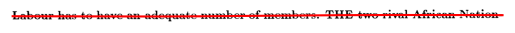

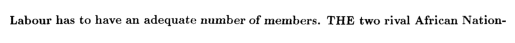

In [7]:
import cv2

# Load the image using OpenCV
image_path = "input/3.png"   # Replace with your image path
output_path = "output/3.png" # Output path for uncurved image

# Read the image using OpenCV
image = cv2.imread(image_path)

# Check if image was loaded
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Set parameters
n_splines = 6           # You can try 6, 12, or more depending on curve complexity
show_plot = True         # Set to False to suppress matplotlib plots
arc_equal = False         # If True, samples equal arc-length segments

uncurve_text_tight(
    image,
    output_path=output_path,
    show_plot=show_plot,
    arc_equal=arc_equal
)
